<a href="https://colab.research.google.com/github/raissalohanna/DataLab-FinalProject/blob/main/NLP_Tweet_Disaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing: Kaggle's Tweet Disaster competition

This project is part of a Kaggle's competition and aims to develop abilities in Natural Language Processing (NLP) problems. Here, the objecive is to predict the occurance of real disasters through the words found in tweets from several places. Available data includes a train set (more detailed information bellow), and a test set. The full submission and final score can be checked at my personal page in Kaggle (to be updated here).

This notebook is inspired in some previous work published in Kaggle.

*References:*

- FeatureExtraction+RandomForestClassifier: https://www.kaggle.com/code/abdulaziz04/featureextraction-randomforestclassifier
- EDA+Preprocessing+Emedding+Model: https://www.kaggle.com/code/rakeshku1993/eda-preprocessing-emedding-model

### Importing the data and querying the first infomations

- **id** - a unique identifier for each tweet
- **text** - the text of the tweet
- **location** - the location the tweet was sent from (may be blank)
- **keyword** - a particular keyword from the tweet (may be blank)
- **target** - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

In [11]:
!pip install pyspellchecker
!pip install category-encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
#Basic package
import pandas as pd

# Math and plot packages
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import STOPWORDS, WordCloud

# Text analysis packages
import re
import string
from nltk.corpus import words
from nltk.corpus import stopwords
from collections import defaultdict
from spellchecker import SpellChecker

# Encoders, tokenizers
import gensim
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from category_encoders import BinaryEncoder

In [13]:
train_data = pd.read_csv('/content/train.csv')
test_data =  pd.read_csv('/content/test.csv')

In [14]:
train_data.shape

(7613, 5)

In [15]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [16]:
test_data.shape

(3263, 4)

In [17]:
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


Text(0.5, 1.0, 'Test set')

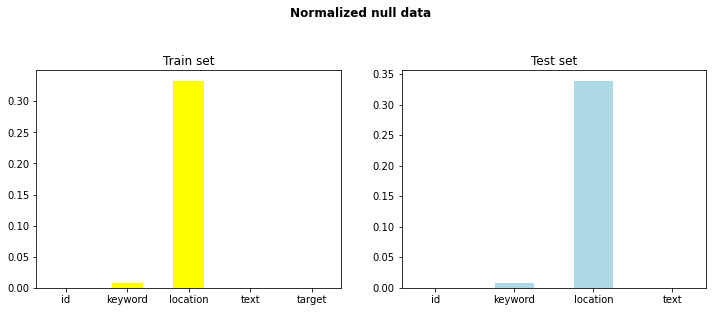

In [18]:
# Checking the amount of null information
trainNull = train_data.isnull().sum()
trainNull_percent = round(trainNull/train_data.shape[0], 3)

testNull = test_data.isnull().sum()
testNull_percent = round(testNull/test_data.shape[0], 3)

labels_train = trainNull.index
labels_test = testNull.index
width = 0.5

# Bar plot
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
fig.suptitle('Normalized null data', y=1.1, weight='bold', size='large')
plt.style.use('seaborn-pastel')

ax1.bar(labels_train, trainNull_percent, width, color='yellow')
ax1.set_title('Train set')
ax2.bar(labels_test, testNull_percent, width, color='lightblue')
ax2.set_title('Test set')

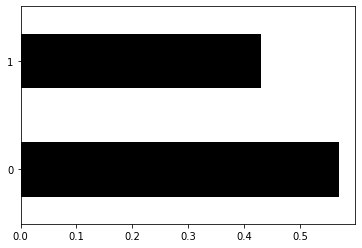

In [19]:
#Checking the balance between target classes
#(1 = real disaster, 0 = no disaster)

train_data['target'].value_counts(normalize=True).plot.barh(color='black')

Text(0.5, 1.0, 'Test set')

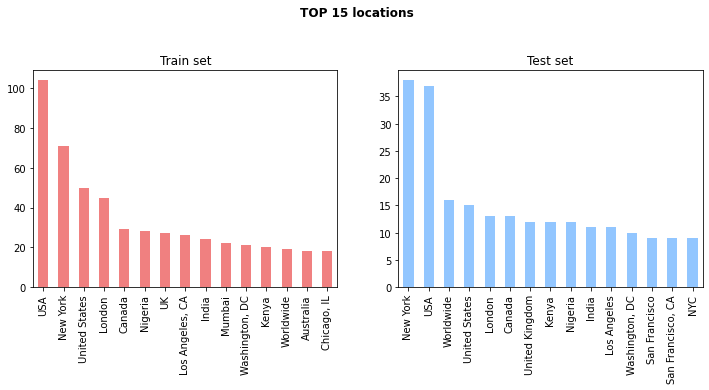

In [20]:
fig2,(ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
fig2.suptitle('TOP 15 locations', y=1.1, weight='bold', size='large')
plt.style.use('seaborn-pastel')

ax1 = train_data['location'].value_counts()[:15].plot.bar(ax=ax1, color='lightcoral')
ax1.set_title('Train set')
ax2 = test_data['location'].value_counts()[:15].plot.bar(ax=ax2)
ax2.set_title('Test set')

In [21]:
train_data.location.value_counts()

USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: location, Length: 3341, dtype: int64

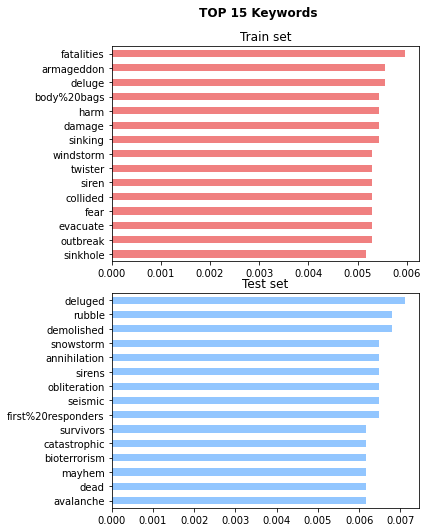

In [22]:
fig2,(ax1, ax2) = plt.subplots(2,1, figsize=(5,7))
fig2.tight_layout()
fig2.suptitle('TOP 15 Keywords', y=1.05, weight='bold', size='large')
plt.style.use('seaborn-pastel')


ax1 = train_data['keyword'].value_counts(normalize=True)[:15].sort_values().plot(kind="barh",
                                                                                 color='lightcoral',
                                                                                 fontsize=10,
                                                                                 title='Train set',
                                                                                 ax=ax1)

ax2 = test_data['keyword'].value_counts(normalize=True)[:15].sort_values().plot(kind="barh",
                                                                                 fontsize=10,
                                                                                 title='Test set',
                                                                                 ax=ax2)

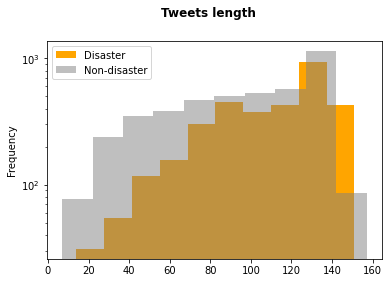

In [23]:
fig3,ax = plt.subplots() 
fig3.figsize=(12,4)
fig3.suptitle('Tweets length', y=1, weight='bold', size='large')

ax = train_data.query("target==1")["text"].str.len().plot(kind="hist",
                                                           color="orange",
                                                           ax=ax)

ax = train_data.query("target==0")["text"].str.len().plot(kind="hist",
                                                           color="gray",
                                                           alpha=0.5,
                                                           ax=ax)
ax.set_yscale('log')
ax.legend(['Disaster', 'Non-disaster'])

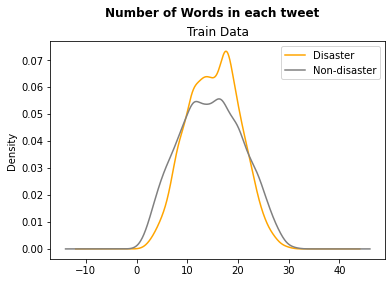

In [24]:
fig4,ax = plt.subplots()
fig4.figsize=(12,4)
fig4.suptitle('Number of Words in each tweet', y=1, weight='bold', size='large')
ax.set_title('Train Data', y=1, weight='light', size='large')

ax = train_data.query("target==1").text.map(lambda x: len(x.split())).plot(kind="kde",
                                                                            color="orange",
                                                                            ax=ax)

ax = train_data.query("target==0").text.map(lambda x: len(x.split())).plot(kind="kde",
                                                                            color="gray",
                                                                            ax=ax)
ax.legend(['Disaster', 'Non-disaster'])

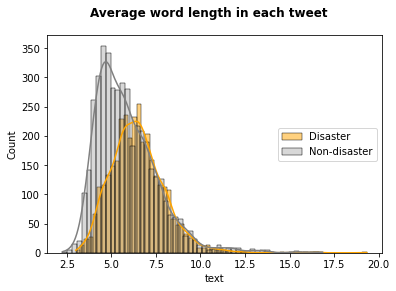

In [25]:
fig5, ax = plt.subplots()
fig5.figsize=(12,5)
fig5.suptitle('Average word length in each tweet', weight='bold')

each_words_len = train_data.query("target==1").text.str.split().map(lambda x: [len(i) for i in x])
sns.histplot(each_words_len.map(lambda x: np.mean(x)), kde=True, ax=ax, color="orange", label='Disaster');

each_words_len = train_data.query("target==0").text.str.split().map(lambda x: [len(i) for i in x])
sns.histplot(each_words_len.map(lambda x: np.mean(x)), kde=True, ax=ax, color='gray', alpha=0.3,  label='Non-disaster');
ax.legend(loc='right')

In [26]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [27]:
def plot_punctuations(df, target):
    
    punctations_dict = defaultdict(int)
    
    for idx, text in df[df["target"]==target].text.iteritems():
        for token in text.split():
            if token in string.punctuation:
                punctations_dict[token] +=1   

    return dict(sorted(punctations_dict.items(), key=lambda x: x[1], reverse=True))


dt_punctuations = plot_punctuations(train_data, target=1)
ndt_punctuations = plot_punctuations(train_data, target=0)

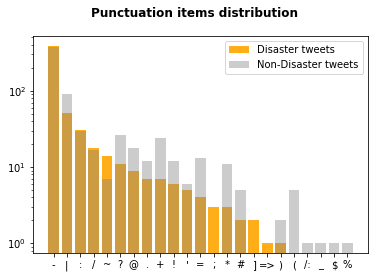

In [28]:
fig6, ax = plt.subplots()
fig6.figsize=(12,5)
fig6.suptitle('Punctuation items distribution', weight='bold')

x1, y1 = zip(*dt_punctuations.items())
ax.bar(x1, y1, color="orange", alpha=0.9, label="Disaster tweets")

x2, y2 = zip(*ndt_punctuations.items())
ax.bar(x2, y2, color="gray", alpha=0.4, label="Non-Disaster tweets")
ax.legend()
ax.set_yscale('log')

In [29]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [30]:
stop_words= set(stopwords.words("english"))

# updating the stopwords considering the following list
stop_words.update(['https', 'http', 'amp', 'CO', 't', 'u', 'new', "I'm", "would"])

wc = WordCloud(width=800,
               height=400,
               max_words=200,
               stopwords=stop_words,
               background_color= "black", 
               colormap="Paired",
               max_font_size=150)

In order to plot de the word cloud, we will use the method **plt.imshow**. According to matplotlib documentation: *Display data as an image, i.e., on a 2D regular raster. The input may either be actual RGB(A) data, or 2D scalar data, which will be rendered as a pseudocolor image.*


Word Cloud for Disaster Tweets


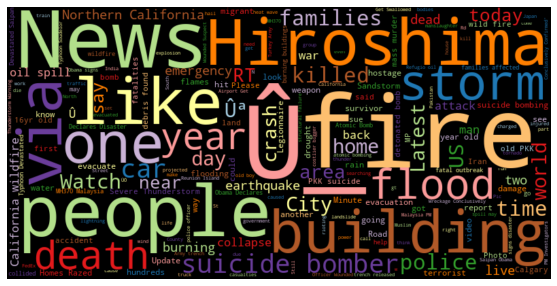


Word Cloud for Non-Disaster Tweets


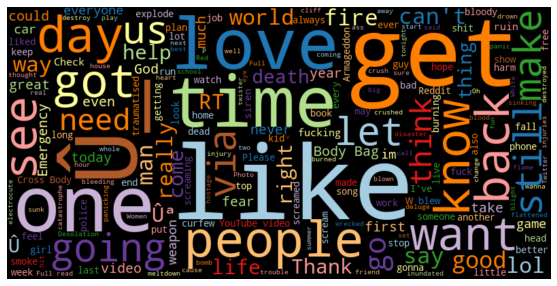

In [31]:
disaster_tweets = (train_data.query("target==1").text).str.cat(sep=" ")  # str.cat -- string concatenation

non_disaster_tweets = (train_data.query("target==0").text).str.cat(sep=" ")

print('\033[1m'"\nWord Cloud for Disaster Tweets"'\033[0m')
wc.generate(disaster_tweets)
plt.figure(figsize=(12, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

print('\033[1m'"\nWord Cloud for Non-Disaster Tweets"'\033[0m')
wc.generate(non_disaster_tweets)
plt.figure(figsize=(12, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

### Feature Engineering

**FEATURE 1:** tweet length (in number of chars)

In [32]:
train_data['num chars'] = train_data["text"].str.len().values
test_data['num chars']  = test_data["text"].str.len().values

In [33]:
train_data.head(2)

,id,keyword,location,text,target,num chars
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38


In [34]:
test_data.head(2)

,id,keyword,location,text,num chars
0,0,NaN,NaN,Just happened a terrible car crash,34
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",64


**FEATURE 2:** number of special chars

In [35]:
def count_special_chars(df):
    
    '''
    Uses regex to identify special chars in text. 
    [^a-zA-Z0-9\s] means: anything in the interval [] that is NOT (^): [a-z] or [A-Z] or [0-9] or \s (space)
    
    Parameters:
        df: Dataset
    Returns: 
        A list with the amount of special chars for each example of the dataset
    
    '''
    special_chars=[]
    
    for text in df['text']:
        special_chars.append(len(re.findall(r'[^a-zA-Z0-9\s]', text)))
    
    return special_chars

In [36]:
train_data['num special chars'] = count_special_chars(train_data)
test_data['num special chars']  =  count_special_chars(test_data)

In [37]:
train_data.head(3)

,id,keyword,location,text,target,num chars,num special chars
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,3


In [38]:
test_data.head(3)

,id,keyword,location,text,num chars,num special chars
0,0,NaN,NaN,Just happened a terrible car crash,34,0
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",64,3
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",96,2


**FEATURE 3:** number of words in each tweet

In [39]:
train_data['num words'] = train_data["text"].map(lambda x: len(x.split()))
test_data['num words']  = test_data["text"].map(lambda x: len(x.split()))

In [40]:
train_data.head(3)

,id,keyword,location,text,target,num chars,num special chars,num words
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,1,13
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,1,7
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,3,22


In [41]:
test_data.head(3)

,id,keyword,location,text,num chars,num special chars,num words
0,0,NaN,NaN,Just happened a terrible car crash,34,0,6
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",64,3,9
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",96,2,19


**FEATURE 4:** average word length

In [42]:
def average_word_length(text):
    
    '''Reads each sentence and creates a list with word lenghts. Following, it returns the mean of the 
    list values'''
    
    spl_text = text.split()
    each_words_len = list(map(lambda x: len(x), spl_text))
    mean = round(sum(each_words_len)/len(each_words_len), 2)
    
    return mean

In [43]:
train_data['average word length'] = train_data["text"].apply(lambda x: average_word_length(x))
test_data['average word length']  = test_data["text"].apply(lambda x: average_word_length(x))

In [44]:
train_data.head(3)

,id,keyword,location,text,target,num chars,num special chars,num words,average word length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,1,13,4.38
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,1,7,4.57
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,3,22,5.09


In [45]:
test_data.head(3)

,id,keyword,location,text,num chars,num special chars,num words,average word length
0,0,NaN,NaN,Just happened a terrible car crash,34,0,6,4.83
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",64,3,9,6.22
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",96,2,19,4.11


**FEATURE 5:** country location

In [46]:
def split_location_countries(df):
    
    countries=[]
    location=[]
    
    for item in df['location'].astype(str).values:
        countries.append(item.split(',')[-1])
        location.append(item.split(',')[0])
        
    df['country']  = countries
    df['location'] = location
    
    assert len(countries)==df.shape[0]
    assert len(countries)==df.shape[0]
        
    return df

In [47]:
train_data = split_location_countries(train_data)
test_data  = split_location_countries(test_data)

In [48]:
def remove_special_chars(text):
    
    '''
    The function removes any char that is not a word character (uppercase or lowercase) and replaces it for
    a simple blank space.
    The regular expression [^a-zA-Z] matches any char that is NOT(^) a word (like special chars, space or
    numbers).
    '''
    
    return re.sub(r"[^a-zA-Z]", " ", text)

In [49]:
train_data['location'] = train_data.location.apply(lambda x: remove_special_chars(x))
test_data['location']  = test_data.location.apply(lambda x: remove_special_chars(x))
train_data['country'] = train_data.location.apply(lambda x: remove_special_chars(x))
test_data['country']  = test_data.location.apply(lambda x: remove_special_chars(x))

In [50]:
train_data.country.value_counts()

nan                       2533
USA                        108
New York                    95
London                      70
United States               50
                          ... 
  T                          1
Live Heed                    1
Waco                         1
North Port                   1
 NewcastleuponTyne  UK       1
Name: country, Length: 2863, dtype: int64

In [53]:
train_data.location.value_counts()

nan                       2533
USA                        108
New York                    95
London                      70
United States               50
                          ... 
  T                          1
Live Heed                    1
Waco                         1
North Port                   1
 NewcastleuponTyne  UK       1
Name: location, Length: 2863, dtype: int64

Importing a table with most important cities in the world to standardize the countries notation

In [54]:
cities = pd.read_csv('/content/worldcities.csv')
cities['city_ascii'] = cities['city_ascii'].str.lower()
cities.head(3)

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,tokyo,35.6839,139.7744,Japan,JP,JPN,Tōkyō,primary,39105000.0,1392685764
1,Jakarta,jakarta,-6.2146,106.8451,Indonesia,ID,IDN,Jakarta,primary,35362000.0,1360771077
2,Delhi,delhi,28.6667,77.2167,India,IN,IND,Delhi,admin,31870000.0,1356872604


In [55]:
columns = ['location', 'country']
for column in columns:
    train_data[column] = train_data[column].str.lower()
    test_data[column]  = test_data[column].str.lower()

In [56]:
def discover_country_from_city(df, column, cities_df):
    
    '''
    Splits the location field and searches for the name of cities to find their respective country
    '''
     
    index=0
    for item in df[column]:
        
        for new_item in item.split():
            if (new_item != 'nan') and (new_item in cities_df['city_ascii'].values):
                df.loc[index, 'country'] = cities_df[cities_df['city_ascii']==new_item].iso2.values[0]
        else:
            pass
        
        index+=1
    
    return df

In [57]:
for colum in columns:
    train_data = discover_country_from_city(train_data, column, cities)
    test_data  = discover_country_from_city(test_data, column, cities)

In [58]:
train_data.country.value_counts()

nan                       2533
US                        1349
GB                         287
JP                         152
CA                         134
                          ... 
hickville                    1
valle del sol                1
in my studio                 1
bod                          1
 newcastleupontyne  uk       1
Name: country, Length: 1567, dtype: int64

In [59]:
train_data[500:504]

,id,keyword,location,text,target,num chars,num special chars,num words,average word length,country
500,725,attacked,lealman,Christian Attacked by Muslims at the Temple Mo...,1,122,9,18,5.83,US
501,726,attacked,los angeles,@envw98 @NickCoCoFree @JulieDiCaro @jdabe80 Wh...,0,136,7,21,5.48,los angeles
502,727,attacked,san francisco,Kelly Osbourne attacked for racist Donald Trum...,1,103,5,14,6.43,ML
503,728,attacked,gdjb asot,@eunice_njoki aiii she needs to chill and answ...,0,89,3,15,5.00,gdjb asot


Cities with double names are affected when we split the location field. To solve it, let's search for the full name of the cities

In [60]:
def discover_country_from_city_v2(df, column, cities_df):
    
    '''
    Uses the location field **with no splitting** and searches for the name of cities to find their 
    respective country
    '''
     
    index=0
    
    for item in df[column]:
        
        if (item != 'nan') and (item in cities_df['city_ascii'].values):
                df.loc[index, 'country'] = cities_df[cities_df['city_ascii']==item].iso2.values[0]
        else:
            pass
        
        index+=1
    
    return df

In [61]:
for column in columns:
    train_data = discover_country_from_city_v2(train_data, column, cities)
    test_data  = discover_country_from_city_v2(test_data, column, cities)

In [62]:
train_data.country.value_counts()

nan                         2533
US                          1540
GB                           290
JP                           152
CA                           135
                            ... 
                               1
silesia                        1
hickville                      1
valle del sol                  1
 newcastleupontyne  uk         1
Name: country, Length: 1503, dtype: int64

In [63]:
train_data[500:504]

,id,keyword,location,text,target,num chars,num special chars,num words,average word length,country
500,725,attacked,lealman,Christian Attacked by Muslims at the Temple Mo...,1,122,9,18,5.83,US
501,726,attacked,los angeles,@envw98 @NickCoCoFree @JulieDiCaro @jdabe80 Wh...,0,136,7,21,5.48,US
502,727,attacked,san francisco,Kelly Osbourne attacked for racist Donald Trum...,1,103,5,14,6.43,US
503,728,attacked,gdjb asot,@eunice_njoki aiii she needs to chill and answ...,0,89,3,15,5.00,gdjb asot


As we have a huge presence of US locations, let us import a USA database with states and main cities

In [64]:
usa_data = pd.read_csv('/content/USAData.csv')

In [65]:
usa_columns = ['name', 'usps', 'State']
for column in usa_columns:
    usa_data[column] = usa_data[column].str.lower()

usa_data.head()

,rank,name,usps,pop2022,pop2010,growth,density,aland_sqmi,State
0,1,new york city,ny,8930002,8175133,0.0923,29729,300.381,new york
1,2,los angeles,ca,3919973,3792621,0.0336,8359,468.956,california
2,3,chicago,il,2756546,2695598,0.0226,12124,227.369,illinois
3,4,houston,tx,2345606,2099451,0.1172,3664,640.194,texas
4,5,phoenix,az,1640641,1445632,0.1349,3169,517.673,arizona


In [66]:
def find_USA_locations(df, column, cities_df):
    
    '''
    Finds USA locations and replace them by 'US' name in country field
    '''
    
    index=0
    usa_columns = ['State', 'usps', 'name']
    
    for item in df[column]:
        
        if item in ['new york', 'united states']:
            df.loc[index, 'country'] = 'US'
        
        else:
            for usa_column in usa_columns:
                if item in cities_df[usa_column].values:
                    df.loc[index, 'country'] = 'US'
                    df.loc[index, 'location']= item
                
                else:
                    pass
        
        index+=1
    
    return df

In [67]:
for column in columns:
    train_data = find_USA_locations(train_data, column, usa_data)
    test_data  = find_USA_locations(test_data, column, usa_data)

In [68]:
train_data.country.value_counts()

nan                       2533
US                        1833
GB                         281
JP                         152
CA                         122
                          ... 
silesia                      1
hickville                    1
valle del sol                1
in my studio                 1
 newcastleupontyne  uk       1
Name: country, Length: 1456, dtype: int64

In [69]:
def find_USA_locations_v2(df, column, cities_df):
    
    '''
    Splits the entries to find US locations
    '''
     
    index=0
    usa_columns = ['State', 'usps', 'name']
    for item in df[column]:
        
        for new_item in item.split():
            for usa_column in usa_columns:
                if new_item in cities_df[usa_column].values:
                    df.loc[index, 'country'] = 'US'
        else:
            pass
        
        index+=1
    
    return df

In [70]:
for column in columns:
    train_data = find_USA_locations_v2(train_data, column, usa_data)
    test_data  = find_USA_locations_v2(test_data, column, usa_data)

In [71]:
train_data.country.value_counts()

nan                          2533
US                           2048
GB                            272
JP                            138
CA                            112
                             ... 
paname city                     1
k  ln                           1
bikini bottom                   1
sharkatraz bindle s cleft       1
 newcastleupontyne  uk          1
Name: country, Length: 1341, dtype: int64

As our Cities database does not comprise all countries in the world, let us import a last, but complete country dataset and search for remaining entries...

In [72]:
countries = pd.read_csv('/content/All countries.csv')

In [73]:
countries['country'] = countries['country'].str.lower()
countries['abbreviation'] = countries['abbreviation'].str.lower()

In [74]:
countries.head()

,abbreviation,country
0,af,afghanistan
1,ax,aland islands
2,al,albania
3,dz,algeria
4,as,american samoa


In [75]:
'us' in countries['abbreviation'].values

True

In [76]:
def search_remaining_countries(df, column, countries_df):
    '''
    Splits the entries to find US locations
    '''
     
    index=0
    for item in df[column]:
        
        if item in countries_df['country'].values:
            df.loc[index, 'country'] = countries_df[countries_df['country']==item].abbreviation.values[0]
        
        else:
            pass
        
        index+=1
    
    return df

In [77]:
train_data = search_remaining_countries(train_data, 'country', countries)
test_data  = search_remaining_countries(test_data, 'country', countries)

In [78]:
train_data['country'].value_counts()

nan                          2533
US                           2048
GB                            272
JP                            138
CA                            112
                             ... 
paname city                     1
k  ln                           1
bikini bottom                   1
sharkatraz bindle s cleft       1
 newcastleupontyne  uk          1
Name: country, Length: 1340, dtype: int64

As we achieved less variation in ['country'] data than in the original ['location'] field, let us work with ['country'] feature from now on. 

To standardize it, the entries with **len(country)>3** and those which does not match any real country abbreviation will be tagged as NaN, as their location is mostly fake and brings no relevant information

In [79]:
def replace_with_nan_v1(df):
    
    '''This version 1 (v1) replaces entries with len()>3 for 'nan' values'''
    
    
    df['country']= np.where(df.country.str.len()>3, 'nan', df['country'])
    
    return df

In [80]:
train_data = replace_with_nan_v1(train_data)
test_data  = replace_with_nan_v1(test_data)

In [81]:
train_data['country'] = train_data['country'].str.upper()
test_data['country']  = test_data['country'].str.upper()

In [82]:
train_data.country.value_counts()

NAN    4017
US     2059
GB      287
CA      145
JP      142
       ... 
PDX       1
AB        1
ZW        1
DFW       1
BF        1
Name: country, Length: 145, dtype: int64

NaN values: 4017


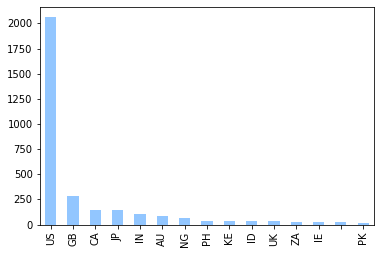

In [83]:
print("NaN values:", train_data.country.value_counts()[0])
train_data.country.value_counts()[1:16].plot.bar()

*Text cleaning and tokenizing*

In [84]:
train_data['text']  = train_data['text'].apply(lambda x : remove_special_chars(x))
test_data['text']   = test_data['text'].apply(lambda x : remove_special_chars(x))

In [85]:
train_data.text

0       Our Deeds are the Reason of this  earthquake M...
1                  Forest fire near La Ronge Sask  Canada
2       All residents asked to  shelter in place  are ...
3              people receive  wildfires evacuation or...
4       Just got sent this photo from Ruby  Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609     aria ahrary  TheTawniest The out of control w...
7610    M            UTC   km S of Volcano Hawaii  htt...
7611    Police investigating after an e bike collided ...
7612    The Latest  More Homes Razed by Northern Calif...
Name: text, Length: 7613, dtype: object

*Methods for stopwords*

In [86]:
import spacy
en = spacy.load('en_core_web_sm')
import gensim
from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

Text(0.5, 1.1, 'Stopwords packages - Size comparison')

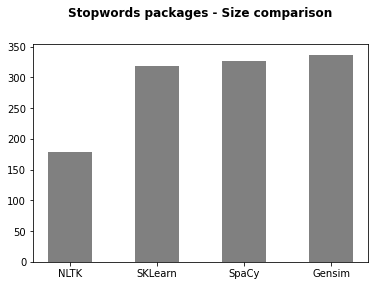

In [87]:
#NLTK
sw_nltk = stopwords.words('english')
nltk_size = len(sw_nltk)

#SKLEARN
sklearn_size = len(ENGLISH_STOP_WORDS)

#GENSIM
gensim_size = len(STOPWORDS)

#SPACY
sw_spacy = en.Defaults.stop_words
spacy_size = len(sw_spacy)

x_values = [nltk_size, sklearn_size, spacy_size, gensim_size]
labels = ['NLTK', 'SKLearn', 'SpaCy', 'Gensim']
width = 0.5

# Bar plot
fig7,ax = plt.subplots()
fig7.figsize=(12,4)

ax.bar(labels, x_values, width, color='gray')
ax.set_title('Stopwords packages - Size comparison', y=1.1, weight='bold', size='large')

In [88]:
spell = SpellChecker()

def correct_spellings(text):
    
    '''Corrects mispelling words'''
    
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
            
    return " ".join(corrected_text)

In [89]:
train_data['text']  = train_data['text'].apply(lambda x : correct_spellings(x))
test_data['text']   = test_data['text'].apply(lambda x : correct_spellings(x))

In [90]:
train_data['text'] = train_data['text'].str.lower()
test_data['text']  = test_data['text'].str.lower()

In [91]:
def gensim_with_lemmantizer(text):
    
    '''Removes stop words and non-English vocabulary using Gensim package and performs lemmatization'''
    
    # Remove stopwords
    clean_text = remove_stopwords(text)
        
    # setting English vocabulary
    english_vocab = set(w.lower() for w in words.words())
    
    # Removing non-English vocabulary
    clean_text = word_tokenize(clean_text)
    tokens = [word for word in clean_text if word in english_vocab]
    
    # Tokenize and Lemmatizing
    lemmatizer = WordNetLemmatizer()
    clean_tokens = []
    
    for token in tokens:
        clean_tokens.append(lemmatizer.lemmatize(token).lower().strip())
     
    return " ".join(clean_tokens)

In [116]:
import nltk
nltk.download('omw-1.4')
nltk.download('words')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [117]:
train_data['text']  = train_data['text'].apply(lambda x : gensim_with_lemmantizer(x))
test_data['text']   = test_data['text'].apply(lambda x : gensim_with_lemmantizer(x))

In [118]:
train_data.head(3)

,id,keyword,location,text,target,num chars,num special chars,num words,average word length,country,country freq,keyword_0,keyword_1,keyword_2,keyword_3,keyword_4,keyword_5,keyword_6,keyword_7
0,1,NA,nan,reason earthquake allah forgive,1,69,1,13,4.38,NAN,0.52765,0,0,0,0,0,0,0,1
1,4,NA,nan,forest near la canada,1,38,1,7,4.57,NAN,0.52765,0,0,0,0,0,0,0,1
2,5,NA,nan,shelter place notified evacuation shelter place,1,133,3,22,5.09,NAN,0.52765,0,0,0,0,0,0,0,1


Creating a backup for future use

In [119]:
# Backup
train_copy = train_data.copy()
test_copy  = test_data.copy()

### Training some ML models

Now, let us try some different ML algorithms using different combinations of encodings.

**Version 1 (v1) set:** 

- 'keywords': binary encoding
- 'contry': frequency encoding
- 'texts': TF-IDF encoding

*Country encoding*

In [120]:
# Group it by type, find the size of each type, and divide by total event

# Train data ("fit_transform")
country_train_freq = train_data.groupby("country").size()/len(train_data)
train_data['country freq'] = train_data['country'].map(country_train_freq) 

# Test data ("transform")
test_data['country freq'] = test_data['country'].map(country_train_freq) 

In [121]:
# Some countries may not appear in the test set. Let us fulfill them with 0 values
countries_id = list(set(test_data['country'].values).difference(set(country_train_freq.index)))
values = [0]*len(countries_id)

assert len(countries_id)==len(values)

exceptions = dict(zip(countries_id, values))

In [122]:
# Correcting these cases one by one..
test_data['country freq'] = test_data['country freq'].map(exceptions)

*Keywords encoding*

In [123]:
train_data['keyword'] = np.where(train_data['keyword'].isnull()==True, 'NA', train_data['keyword'])
test_data['keyword']  = np.where(test_data['keyword'].isnull()==True, 'NA', test_data['keyword'])

In [124]:
train_data['keyword']  = train_data['keyword'].apply(lambda x : remove_special_chars(x))
test_data['keyword']   = test_data['keyword'].apply(lambda x : remove_special_chars(x))

In [125]:
def binary_encoder(df, column):
    
    be = BinaryEncoder(cols=[column])
    newdata = be.fit_transform(df[column])
    
    assert newdata.shape[0]==df.shape[0]
    
    df = pd.concat([df, newdata], axis=1)
    
    return df

In [126]:
train_data = binary_encoder(train_data, 'keyword')
test_data  = binary_encoder(test_data, 'keyword')

*Text encoding*

In [127]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf_vectorizer(df_train, df_test):
        
    vectorizer = TfidfVectorizer(tokenizer=word_tokenize, token_pattern=None)
    
    # For Train Set
    train_texts = vectorizer.fit_transform(df_train['text'])
    train_texts = pd.DataFrame(train_texts.toarray(), columns=vectorizer.get_feature_names_out())
    df_train = pd.concat([df_train, train_texts], axis=1)

    # For Test Set
    test_texts  = vectorizer.transform(df_test['text'])
    test_texts = pd.DataFrame(test_texts.toarray(), columns=vectorizer.get_feature_names_out())
    df_test = pd.concat([df_test, test_texts], axis=1)
    
    return df_train, df_test

In [128]:
xtrain_v1, xtest_v1 = tfidf_vectorizer(train_data, test_data)

In [129]:
xtrain_v1 = xtrain_v1.drop(columns=['id', 'keyword', 'location', 'text', 'country', 'target'])
xtest_v1 = xtest_v1.drop(columns=['id', 'keyword', 'location', 'text', 'country'])
ytrain = train_data['target']

In [130]:
xtrain_v1.head(3)

,num chars,num special chars,num words,average word length,country freq,keyword_0,keyword_1,keyword_2,keyword_3,keyword_4,...,zionism,zionist,zip,zipper,zo,zodiac,zombie,zone,zoo,zoom
0,69,1,13,4.38,0.52765,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,38,1,7,4.57,0.52765,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,133,3,22,5.09,0.52765,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


*Model training*

In [131]:
# Pre processing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Metrics
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score, make_scorer

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold

# Methods
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [132]:
#Setting pipelines

#Logistic Regression
pipe_LR = Pipeline([('scalar', StandardScaler()), 
                    ('LR', LogisticRegression(max_iter=10000, tol=0.1, solver='saga'))])

#RandomForest
pipe_RF = Pipeline([("RF", RandomForestClassifier())])

#LGBM
pipe_LGBM = Pipeline([("LGBM", LGBMClassifier())])

pipelines = [pipe_LR, pipe_RF, pipe_LGBM]

In [133]:
#Setting parameters

#Logistic Regression
param_LR = {"LR__C": [0.01, 0.1, 1],
            "LR__penalty":['l1','l2']}

#RandomForest
param_RF = {"RF__n_estimators": [100, 150, 200],
            "RF__max_depth":[7, 10, 15]}
                   
#LGBM
param_LGBM = {"LGBM__n_estimators": [50, 75, 100],
              "LGBM__learning_rate":[0.001, 0.01, 0.1],
              "LGBM__max_depth": [3, 5, 10]} 

parameters = [param_LR, param_RF, param_LGBM]

In [134]:
#Dictionary of models
models_dict = {0: 'Logistic Regression',
          1: 'Random Forest',
          2: 'Light GBM'}

#Scores to be evaluated
scoring_list = ["roc_auc", "accuracy"]

#List of Grid Search results
searches_v1 = [0]*len(models_dict)

In [135]:
# Spitting datasets
xtrain_v1, xvalid_v1, ytrain, yvalid_v1 = train_test_split(xtrain_v1, ytrain, test_size=0.15, random_state=42)

# Printing data sets info
print('------ Train, Validation and Test sets info ------')
print('X train size:', xtrain_v1.shape)
print('Y train size:', ytrain.shape)
print('X validation size:', xvalid_v1.shape)
print('Y validation size:', yvalid_v1.shape)
print('X test size:', xtest_v1.shape)


# set the Grid search CV
for model in range(len(pipelines)):
    searches_v1[model] = GridSearchCV(estimator = pipelines[model], 
                             param_grid = parameters[model], 
                             n_jobs = 2, 
                             scoring = scoring_list,
                             refit = 'roc_auc',
                             verbose = 2,
                             return_train_score = True,
                             cv = 5
                            )
    
    searches_v1[model].fit(xtrain_v1, ytrain)

    # Printing grid search info
    print('------ Grid Search results for:', models_dict[model],' ------')
    print("Best parameter (CV score=%0.3f):" % searches_v1[model].best_score_)
    print("Best parameters: ", searches_v1[model].best_params_)
    print("Best index: ", searches_v1[model].best_index_)
    print("Best estimator: ", searches_v1[model].best_estimator_)
    print('---------------------------------------------')

------ Train, Validation and Test sets info ------
X train size: (6471, 7199)
Y train size: (6471,)
X validation size: (1142, 7199)
Y validation size: (1142,)
X test size: (3263, 7200)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
------ Grid Search results for: Logistic Regression  ------
Best parameter (CV score=0.822):
Best parameters:  {'LR__C': 0.1, 'LR__penalty': 'l1'}
Best index:  2
Best estimator:  Pipeline(steps=[('scalar', StandardScaler()),
                ('LR',
                 LogisticRegression(C=0.1, max_iter=10000, penalty='l1',
                                    solver='saga', tol=0.1))])
---------------------------------------------
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


------ Grid Search results for: Random Forest  ------
Best parameter (CV score=0.798):
Best parameters:  {'RF__max_depth': 15, 'RF__n_estimators': 200}
Best index:  8
Best estimator:  Pipeline(steps=[('RF', RandomForestClassifier(max_depth=15, n_estimators=200))])
---------------------------------------------
Fitting 5 folds for each of 27 candidates, totalling 135 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


------ Grid Search results for: Light GBM  ------
Best parameter (CV score=0.824):
Best parameters:  {'LGBM__learning_rate': 0.1, 'LGBM__max_depth': 10, 'LGBM__n_estimators': 100}
Best index:  26
Best estimator:  Pipeline(steps=[('LGBM', LGBMClassifier(max_depth=10))])
---------------------------------------------


In [136]:
#results_v1 = searches[model].cv_results_
#method_v1 = searches[model].best_estimator_

In [137]:
searches_v1[0].best_score_

0.8219312239571028

**Version 2 (v1) set:** 

- 'keywords': binary encoding
- 'contry': frequency encoding
- 'texts': SpaCy encoding

*Text encoding*

In [138]:
!python -m spacy download en_core_web_md

2022-08-27 10:57:12.626774: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42.8 MB 34.4 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [139]:
from sklearn.base import BaseEstimator, TransformerMixin

class WordVectorTransformer(TransformerMixin,BaseEstimator):
    def __init__(self, model="en_core_web_md"):
        self.model = model

    def fit(self,X,y=None):
        return self

    def transform(self,X):
        nlp = spacy.load(self.model)
        return np.concatenate([nlp(doc).vector.reshape(1,-1) for doc in X])

In [140]:
def spacy_transform(df_train, df_test, feature):
  transformer = WordVectorTransformer()
  
  #encoding
  train_arr = transformer.fit_transform(df_train[feature])
  test_arr  = transformer.fit_transform(df_test[feature])

  #converting to DataFrame
  df_train_txt = pd.DataFrame(train_arr, columns =['txt'+str(i) for i in range(1,301)])
  df_test_txt  = pd.DataFrame(test_arr, columns =['txt'+str(i) for i in range(1,301)])

  df_train = pd.concat([df_train, df_train_txt], axis=1)
  df_test =  pd.concat([df_test, df_test_txt], axis=1)

  return df_train, df_test

In [141]:
xtrain_v2, xtest_v2 = spacy_transform(train_data, test_data, 'text')

In [142]:
xtrain_v2 = xtrain_v2.drop(columns=['id', 'keyword', 'location', 'text', 'country', 'target'])
xtest_v2 = xtest_v2.drop(columns=['id', 'keyword', 'location', 'text', 'country'])
ytrain = train_data['target']

In [143]:
xtrain_v2.head(3)

,num chars,num special chars,num words,average word length,country freq,keyword_0,keyword_1,keyword_2,keyword_3,keyword_4,...,txt291,txt292,txt293,txt294,txt295,txt296,txt297,txt298,txt299,txt300
0,69,1,13,4.38,0.52765,0,0,0,0,0,...,3.753675,-0.973575,0.807835,-0.427525,-0.404525,1.622118,1.224605,-0.881025,-2.046537,1.265052
1,38,1,7,4.57,0.52765,0,0,0,0,0,...,-1.024685,2.021043,4.444325,1.457075,0.132725,1.300485,1.729575,-0.197270,-0.915400,-2.731612
2,133,3,22,5.09,0.52765,0,0,0,0,0,...,-0.725623,-1.385352,0.817780,2.724800,-4.064633,-0.608247,-1.015070,-1.789082,0.803580,0.772050


*Model training*

In [144]:
#List of Grid Search results
searches_v2 = [0]*len(models_dict)

In [145]:
# Spitting datasets
xtrain_v2, xvalid_v2, ytrain, yvalid_v2 = train_test_split(xtrain_v2, ytrain, test_size=0.15, random_state=42)

# Printing data sets info
print('------ Train, Validation and Test sets info ------')
print('X train size:', xtrain_v2.shape)
print('Y train size:', ytrain.shape)
print('X validation size:', xvalid_v2.shape)
print('Y validation size:', yvalid_v2.shape)
print('X test size:', xtest_v2.shape)


# set the Grid search CV
for model in range(len(pipelines)):
    searches_v2[model] = GridSearchCV(estimator = pipelines[model], 
                             param_grid = parameters[model], 
                             n_jobs = 2, 
                             scoring = scoring_list,
                             refit = 'roc_auc',
                             verbose = 2,
                             return_train_score = True,
                             cv = 5
                            )
    
    searches_v2[model].fit(xtrain_v2, ytrain)

    # Printing grid search info
    print('------ Grid Search results for:', models_dict[model],' ------')
    print("Best parameter (CV score=%0.3f):" % searches_v2[model].best_score_)
    print("Best parameters: ", searches_v2[model].best_params_)
    print("Best index: ", searches_v2[model].best_index_)
    print("Best estimator: ", searches_v2[model].best_estimator_)
    print('---------------------------------------------')

------ Train, Validation and Test sets info ------
X train size: (6471, 321)
Y train size: (6471,)
X validation size: (1142, 321)
Y validation size: (1142,)
X test size: (3263, 321)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
------ Grid Search results for: Logistic Regression  ------
Best parameter (CV score=0.827):
Best parameters:  {'LR__C': 1, 'LR__penalty': 'l2'}
Best index:  5
Best estimator:  Pipeline(steps=[('scalar', StandardScaler()),
                ('LR',
                 LogisticRegression(C=1, max_iter=10000, solver='saga',
                                    tol=0.1))])
---------------------------------------------
Fitting 5 folds for each of 9 candidates, totalling 45 fits
------ Grid Search results for: Random Forest  ------
Best parameter (CV score=0.817):
Best parameters:  {'RF__max_depth': 10, 'RF__n_estimators': 150}
Best index:  4
Best estimator:  Pipeline(steps=[('RF', RandomForestClassifier(max_depth=10, n_estimators=150))])
---------------------

**Version 3 (v3) set:** 

- 'keywords': SpaCy encoding
- 'country': frequency encoding
- 'texts': SpaCy encoding

*Keyword encoding*

In [146]:
xtrain_v3, xtest_v3 = spacy_transform(train_data, test_data, 'keyword')

*Text encoding*

In [147]:
xtrain_v3, xtest_v3 = spacy_transform(xtrain_v3, xtest_v3, 'text')

In [148]:
xtrain_v3 = xtrain_v3.drop(columns= ['id', 'keyword', 'location', 'text', 'country', 'target'])
xtest_v3 = xtest_v3.drop(columns= ['id', 'keyword', 'location', 'text', 'country'])
ytrain = train_data['target']

In [149]:
xtrain_v3.shape

(7613, 621)

*Model training*

In [150]:
#List of Grid Search results
searches_v3 = [0]*len(models_dict)

In [151]:
# Spitting datasets
xtrain_v3, xvalid_v3, ytrain, yvalid_v3 = train_test_split(xtrain_v3, ytrain, test_size=0.15, random_state=42)

# Printing data sets info
print('------ Train, Validation and Test sets info ------')
print('X train size:', xtrain_v3.shape)
print('Y train size:', ytrain.shape)
print('X validation size:', xvalid_v3.shape)
print('Y validation size:', yvalid_v3.shape)
print('X test size:', xtest_v3.shape)


# set the Grid search CV
for model in range(len(pipelines)):
    searches_v3[model] = GridSearchCV(estimator = pipelines[model], 
                             param_grid = parameters[model], 
                             n_jobs = 2, 
                             scoring = scoring_list,
                             refit = 'roc_auc',
                             verbose = 2,
                             return_train_score = True,
                             cv = 5
                            )
    
    searches_v3[model].fit(xtrain_v3, ytrain)

    # Printing grid search info
    print('------ Grid Search results for:', models_dict[model],' ------')
    print("Best parameter (CV score=%0.3f):" % searches_v3[model].best_score_)
    print("Best parameters: ", searches_v3[model].best_params_)
    print("Best index: ", searches_v3[model].best_index_)
    print("Best estimator: ", searches_v3[model].best_estimator_)
    print('---------------------------------------------')

------ Train, Validation and Test sets info ------
X train size: (6471, 621)
Y train size: (6471,)
X validation size: (1142, 621)
Y validation size: (1142,)
X test size: (3263, 621)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
------ Grid Search results for: Logistic Regression  ------
Best parameter (CV score=0.844):
Best parameters:  {'LR__C': 0.1, 'LR__penalty': 'l2'}
Best index:  3
Best estimator:  Pipeline(steps=[('scalar', StandardScaler()),
                ('LR',
                 LogisticRegression(C=0.1, max_iter=10000, solver='saga',
                                    tol=0.1))])
---------------------------------------------
Fitting 5 folds for each of 9 candidates, totalling 45 fits
------ Grid Search results for: Random Forest  ------
Best parameter (CV score=0.842):
Best parameters:  {'RF__max_depth': 15, 'RF__n_estimators': 200}
Best index:  8
Best estimator:  Pipeline(steps=[('RF', RandomForestClassifier(max_depth=15, n_estimators=200))])
-----------------

**Version 4 (v4) set:** 

- 'keywords': SpaCy encoding
- 'contry': SpaCy encoding
- 'texts': SpaCy encoding

*Country encoding*

In [152]:
xtrain_v4, xtest_v4 = spacy_transform(train_data, test_data, 'country')

*Keyword encoding*

In [153]:
xtrain_v4, xtest_v4 = spacy_transform(xtrain_v4, xtest_v4, 'keyword')

*Text encoding*

In [154]:
xtrain_v4, xtest_v4 = spacy_transform(xtrain_v4, xtest_v4, 'text')

In [155]:
xtrain_v4 = xtrain_v4.drop(columns=['id', 'keyword', 'location', 'text', 'country', 'target','country freq'])
xtest_v4 = xtest_v4.drop(columns=['id', 'keyword', 'location', 'text', 'country', 'country freq'])
ytrain = train_data['target']

In [156]:
xtrain_v4.head(3)

,num chars,num special chars,num words,average word length,keyword_0,keyword_1,keyword_2,keyword_3,keyword_4,keyword_5,...,txt291,txt292,txt293,txt294,txt295,txt296,txt297,txt298,txt299,txt300
0,69,1,13,4.38,0,0,0,0,0,0,...,3.753675,-0.973575,0.807835,-0.427525,-0.404525,1.622118,1.224605,-0.881025,-2.046537,1.265052
1,38,1,7,4.57,0,0,0,0,0,0,...,-1.024685,2.021043,4.444325,1.457075,0.132725,1.300485,1.729575,-0.197270,-0.915400,-2.731612
2,133,3,22,5.09,0,0,0,0,0,0,...,-0.725623,-1.385352,0.817780,2.724800,-4.064633,-0.608247,-1.015070,-1.789082,0.803580,0.772050


In [157]:
# Splitting datasets
xtrain_v4, xvalid_v4, ytrain, yvalid_v4 = train_test_split(xtrain_v4, ytrain, test_size=0.15, random_state=42)

# Printing data sets info
print('------ Train, Validation and Test sets info ------')
print('X train size:', xtrain_v4.shape)
print('Y train size:', ytrain.shape)
print('X validation size:', xvalid_v4.shape)
print('Y validation size:', yvalid_v4.shape)
print('X test size:', xtest_v4.shape)

# initiate the ML model using Gini Impurity algorithm (default)
pipe = Pipeline([("LGBM", LGBMClassifier())])
param_grid = {"LGBM__n_estimators": [50, 75, 100],
              "LGBM__learning_rate":[0.001, 0.01, 0.1],
              "LGBM__max_depth": [3, 5, 10]
             }

# set the Grid search CV
search_v4 = GridSearchCV(pipe, 
                      param_grid, 
                      n_jobs=2, 
                      scoring=scoring_list,
                      refit='roc_auc',
                      verbose=2,
                      return_train_score=True,
                      cv=5
                     )

search_v4.fit(xtrain_v4, ytrain)
results_v4 = search_v4.cv_results_
method_v4 = search_v4.best_estimator_

# Printing grid search info
print('------ Grid Search results for: Light GBM ----------')
print("Best parameter (CV score=%0.3f):" % search_v4.best_score_)
print("Best parameters: ", search_v4.best_params_)
print("Best index: ", search_v4.best_index_)
print("Best estimator: ", search_v4.best_estimator_)

------ Train, Validation and Test sets info ------
X train size: (6471, 920)
Y train size: (6471,)
X validation size: (1142, 920)
Y validation size: (1142,)
X test size: (3263, 920)
Fitting 5 folds for each of 27 candidates, totalling 135 fits
------ Grid Search results for: Light GBM ----------
Best parameter (CV score=0.851):
Best parameters:  {'LGBM__learning_rate': 0.1, 'LGBM__max_depth': 5, 'LGBM__n_estimators': 100}
Best index:  23
Best estimator:  Pipeline(steps=[('LGBM', LGBMClassifier(max_depth=5))])


## Metrics

*Resume*

In [158]:
versions = {0: {'text': 'TF-IDF',
                   'keywords': 'binary',
                   'country': 'frequency'},
            1: {'text': 'SpaCy',
                   'keywords': 'binary',
                   'country': 'frequency'},
            2: {'text': 'SpaCy',
                   'keywords': 'SpaCy',
                   'country': 'frequency'},
            3: {'text': 'SpaCy',
                   'keywords': 'SpaCy',
                   'country': 'SpaCy'}}
                   
versions = pd.DataFrame.from_dict(versions).T
versions

,text,keywords,country
0,TF-IDF,binary,frequency
1,SpaCy,binary,frequency
2,SpaCy,SpaCy,frequency
3,SpaCy,SpaCy,SpaCy


In [159]:
best_models = {'LR': [searches_v1[0].best_score_, searches_v2[0].best_score_, searches_v3[0].best_score_, '-'],
               'RF': [searches_v1[1].best_score_, searches_v2[1].best_score_, searches_v3[1].best_score_, '-'],
               'LGBM': [searches_v1[2].best_score_, searches_v2[2].best_score_, searches_v3[2].best_score_, search_v4.best_score_],
               }

best_models = pd.DataFrame.from_dict(best_models)
best_models

,LR,RF,LGBM
0,0.821931,0.797913,0.823595
1,0.827299,0.816537,0.829411
2,0.844374,0.842293,0.850547
3,-,-,0.850763


In [177]:
final_table = pd.concat([versions, best_models], axis=1)
final_table['version'] = ['v1', 'v2', 'v3', 'v4']
final_table = final_table[['version', 'text', 'keywords', 'country', 'LR', 'RF', 'LGBM']]
final_table

,version,text,keywords,country,LR,RF,LGBM
0,v1,TF-IDF,binary,frequency,0.821931,0.797913,0.823595
1,v2,SpaCy,binary,frequency,0.827299,0.816537,0.829411
2,v3,SpaCy,SpaCy,frequency,0.844374,0.842293,0.850547
3,v4,SpaCy,SpaCy,SpaCy,-,-,0.850763


In [176]:
final_table.to_csv('NLP results.csv', index=False)

*ROC curve*

In [161]:
xtrain_v3.shape

(6471, 621)

In [162]:
xtest_v3.shape

(3263, 621)

In [186]:
#predicting results with the best models
LR_v1 = searches_v1[0].best_estimator_
LGBM_v3 = searches_v3[2].best_estimator_
LGBM_v4 = search_v4.best_estimator_

#for ROC curve
yscore_LR = LR_v1.predict_proba(xvalid_v1)[:, 1]
yscore_LGBMv3 = LGBM_v3.predict_proba(xvalid_v3)[:, 1]
yscore_LGBMv4 = LGBM_v4.predict_proba(xvalid_v4)[:, 1]

In [168]:
from sklearn.metrics import roc_curve, auc

#Compute ROC curve and ROC area for each class

fpr = dict()  #False Positive Rates
tpr = dict()  #True Positive Rates
roc_auc = dict()

# generate a no skill (ns) prediction (majority class) 
ns_probs = [0 for _ in range(len(yvalid_v3))]

# calculate scores
ns_auc = roc_auc_score(yvalid_v3, ns_probs)
LR_auc = searches_v1[0].best_score_
LGBMv3_auc = searches_v3[2].best_score_
LGBMv4_auc = search_v4.best_score_

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(yvalid_v3, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(yvalid_v1, yscore_LR)
lgbmv3_fpr, lgbmv3_tpr, _ = roc_curve(yvalid_v3, yscore_LGBMv3)
lgbmv4_fpr, lgbmv4_tpr, _ = roc_curve(yvalid_v4, yscore_LGBMv4)


# summarize scores
print('Logistic: ROC AUC=%.3f' % (LR_auc))
print('Light GBM (v3): ROC AUC=%.3f' % (LGBMv3_auc))
print('Light GBM (v4): ROC AUC=%.3f' % (LGBMv4_auc))

Logistic: ROC AUC=0.822
Light GBM (v3): ROC AUC=0.851
Light GBM (v4): ROC AUC=0.851


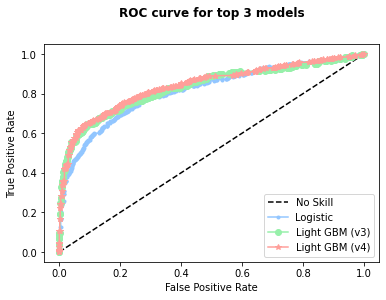

In [174]:
# plot the ROC curve for the model

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill', color='black')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
plt.plot(lgbmv3_fpr, lgbmv3_tpr, marker='o', label='Light GBM (v3)')
plt.plot(lgbmv4_fpr, lgbmv4_tpr, marker='*', label='Light GBM (v4)')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()
plt.title('ROC curve for top 3 models', weight='bold', y=1.1)

# show the plot
plt.show()

*Calibration curve*

In [175]:
from matplotlib.gridspec import GridSpec
from sklearn.calibration import CalibrationDisplay

In [178]:
# Model Calibration
def calib_curve_probs(y_true, y_probs, n_bins: int = 10, method: str = 'uniform'):
    """Binary classification calibration curve and probas
    Parameters
    ----------
    y_true: array
        true class observations
    y_preds: array
        model predictions
    n_bins: int (default = 10)
    method: str (default = "uniform")
        whether to use "uniform" or "quantile" for probability binning
    Returns
    -------
    x, y, p: Average score, Fra
    
    """
    assert method in ['quantile', 'uniform'], "Unrecognized method"
    
    predictions = pd.DataFrame({
        'label': y_true,
        'scores': y_probs,
        })
    
    predictions = predictions.sort_values('scores')
    
    if method == 'quantile':
        quantiles = [predictions['scores'].quantile(q) for q in np.linspace(0, 1, n_bins+1)] 
        predictions['bins'] = pd.cut(predictions['scores'], quantiles)

    else:
        bins=np.linspace(0, 1, n_bins+1) 
        predictions['bins'] = pd.cut(predictions['scores'], bins)
        
    # we can now aggregate: average y=1 per chunk and average score per chunk
    calibration = predictions.groupby('bins').mean().reset_index(drop=True)
    calibration.columns = ['Fraction of positives', 'Average score']
    
    x, y = calibration['Average score'], calibration['Fraction of positives']
    p = predictions.groupby('bins').\
                   apply(lambda x: len(x)).\
                   values
    p = p/len(y_true)
    
    return x, y, p

In [179]:
def plot_calibration_curve(y_true, y_probs, 
                            n_bins: int = 10, 
                            method: str ='uniform', 
                            ax = None, 
                            legend: str = None):
    """Plots calibration curve for the binary classification setup
    Parameters
    ----------
    y_true: array
        true class observations
    y_probs: array
        model class probability estimates
    method: str (default = 'uniform') 
        whether to use 'uniform' or 'quantile' binning 
    ax: default = None
    legend: str (default = None)
    
    Returns
    -------
    ax
    """
    
    x, y, p = calib_curve_probs(y_true, y_probs, n_bins=n_bins, method=method)

    p = p/p.max() + p.min()
    if ax is None:
        f, ax = plt.subplots(dpi = 120)   
        
    ax.scatter(x, y, s=100*p, marker='o',  alpha = 0.8)
    ax.plot(x,y, label=legend, alpha = 0.8)
    ax.plot([0,1], linestyle='--', color='gray')
    ax.set_xlabel("Mean predicted probability")
    ax.set_ylabel("Fraction of positives")
    
    if legend is not None:
        ax.legend(frameon = False)
    return ax

In [189]:
yscore_LR_full = LR_v1.predict_proba(xvalid_v1)
yscore_LGBMv3_full = LGBM_v3.predict_proba(xvalid_v3)

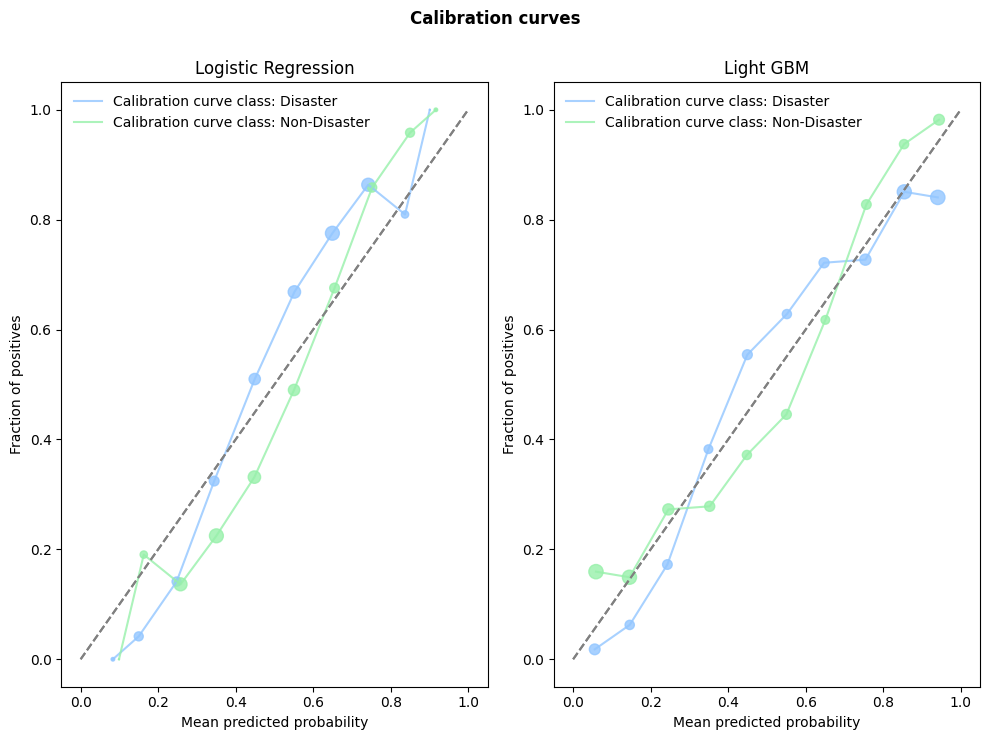

In [200]:
classes = {'Disaster': 0, 'Non-Disaster': 1}
f, (ax1, ax2) = plt.subplots(1,2, figsize=(10,7), dpi=100)


for class_name, class_ in classes.items():
    plot_calibration_curve(yvalid_v1.apply(lambda x : 1 if x == class_ else 0), 
                            yscore_LR_full[:, class_],
                            ax = ax1, 
                            legend = f'Calibration curve class: {class_name}')
ax1.set_title('Logistic Regression')
    
for class_name, class_ in classes.items():
    plot_calibration_curve(yvalid_v3.apply(lambda x : 1 if x == class_ else 0), 
                            yscore_LGBMv3_full[:, class_],
                            ax = ax2, 
                            legend = f'Calibration curve class: {class_name}')
ax2.set_title('Light GBM')
    
f.suptitle('Calibration curves',  weight='bold', y=1.05)
f.tight_layout()
plt.show()

*SHAP values*

In [202]:
!pip install shap
import shap 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 4.3 MB/s 


In [203]:
# Fits the explainer
explainer_LR = shap.Explainer(LR_v1.predict, xvalid_v1)
explainer_LGBMv3 = shap.Explainer(LGBM_v3.predict, xvalid_v3)

In [205]:
# Calculates the SHAP values - It takes some time
shap_values_LR = explainer_LR(xvalid_v1)
shap_values_LGBMv3 = explainer_LGBMv3(xvalid_v3)

ValueError: ignored

*Evaluating the global effect of values*

Here the features are ordered from the highest to the lowest effect on the prediction. It takes in account the absolute SHAP value, so it does not matter if the feature affects the prediction in a positive or negative way.

In [ ]:
shap.plots.bar(shap_values)

In [ ]:
shap.summary_plot(shap_values, plot_type='violin')